In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, mutual_info_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [2]:
df_full_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [3]:
# mutual info function
def calculate_mi(series):
    return mutual_info_score(series, df_full_train.smoking)

In [ ]:
def kfold_eval(model, full_train, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    aucs = []
    for train_idx, val_idx in kfold.split(full_train):
            df_train = df_full_train.iloc[train_idx]
            df_val = df_full_train.iloc[val_idx]
            
            X_train = df_train.drop(columns='smoking')
            X_val = df_val.drop(columns='smoking')
            
            y_train = df_train.smoking.values
            y_val = df_val.smoking.values
            
            model.fit(X_train, y_train)

            y_pred = model.predict_proba(X_val)[:,1]

            # evaluation
            auc = roc_auc_score(y_val, y_pred)
            aucs.append(auc)
    return np.mean(aucs), np.std(aucs)

# EDA

**Column names formating**

In [4]:
# full training dataset preparation
# lowercase column name
df_full_train.columns = df_full_train.columns.str.lower().str.replace(' ', '_')
df_test.columns = df_test.columns.str.lower().str.replace(' ', '_')

**drop "id" column**

In [5]:
df_full_train = df_full_train.drop(columns='id')
df_test = df_test.drop(columns='id')

**Missing check**

In [6]:
missing_columns_full_train = df_full_train.isnull().sum()
print('Missing train column ->',missing_columns_full_train[missing_columns_full_train > 0])
missing_columns_test = df_test.isnull().sum()
print('Missing test column->',missing_columns_test[missing_columns_test > 0])

Missing train column -> Series([], dtype: int64)
Missing test column-> Series([], dtype: int64)


**duplicated check**

In [7]:
if df_full_train.duplicated().any():
    print('---Duplicates exist---')
else:
    print('---No duplicates---')

---No duplicates---


**dtypes check**

In [8]:
df_full_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Columns: 23 entries, age to smoking
dtypes: float64(5), int64(18)
memory usage: 27.9 MB


In [9]:
df_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106171 entries, 0 to 106170
Columns: 22 entries, age to dental_caries
dtypes: float64(5), int64(17)
memory usage: 17.8 MB


In [10]:
df_full_train.head(10)

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,dental_caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1
5,50,170,55,51.0,1.2,1.2,1,1,146,95,...,31,99,15.9,1,0.7,24,42,119,1,1
6,45,160,55,69.0,1.5,1.2,1,1,150,88,...,69,122,13.0,1,0.7,17,12,16,0,0
7,55,155,60,84.5,0.7,0.9,1,1,137,91,...,51,198,14.5,1,0.7,16,15,16,0,0
8,40,165,70,89.0,0.7,1.0,1,1,130,80,...,59,150,15.7,1,0.9,24,21,31,0,1
9,40,155,50,73.0,1.5,1.5,1,1,105,70,...,55,122,13.2,1,0.7,22,16,14,0,0


**target variable insight**

In [11]:
y_full_train = df_full_train['smoking']

y_full_train.value_counts(normalize=True).round(2)

smoking
0    0.56
1    0.44
Name: proportion, dtype: float64

**plot every feature's distribution**

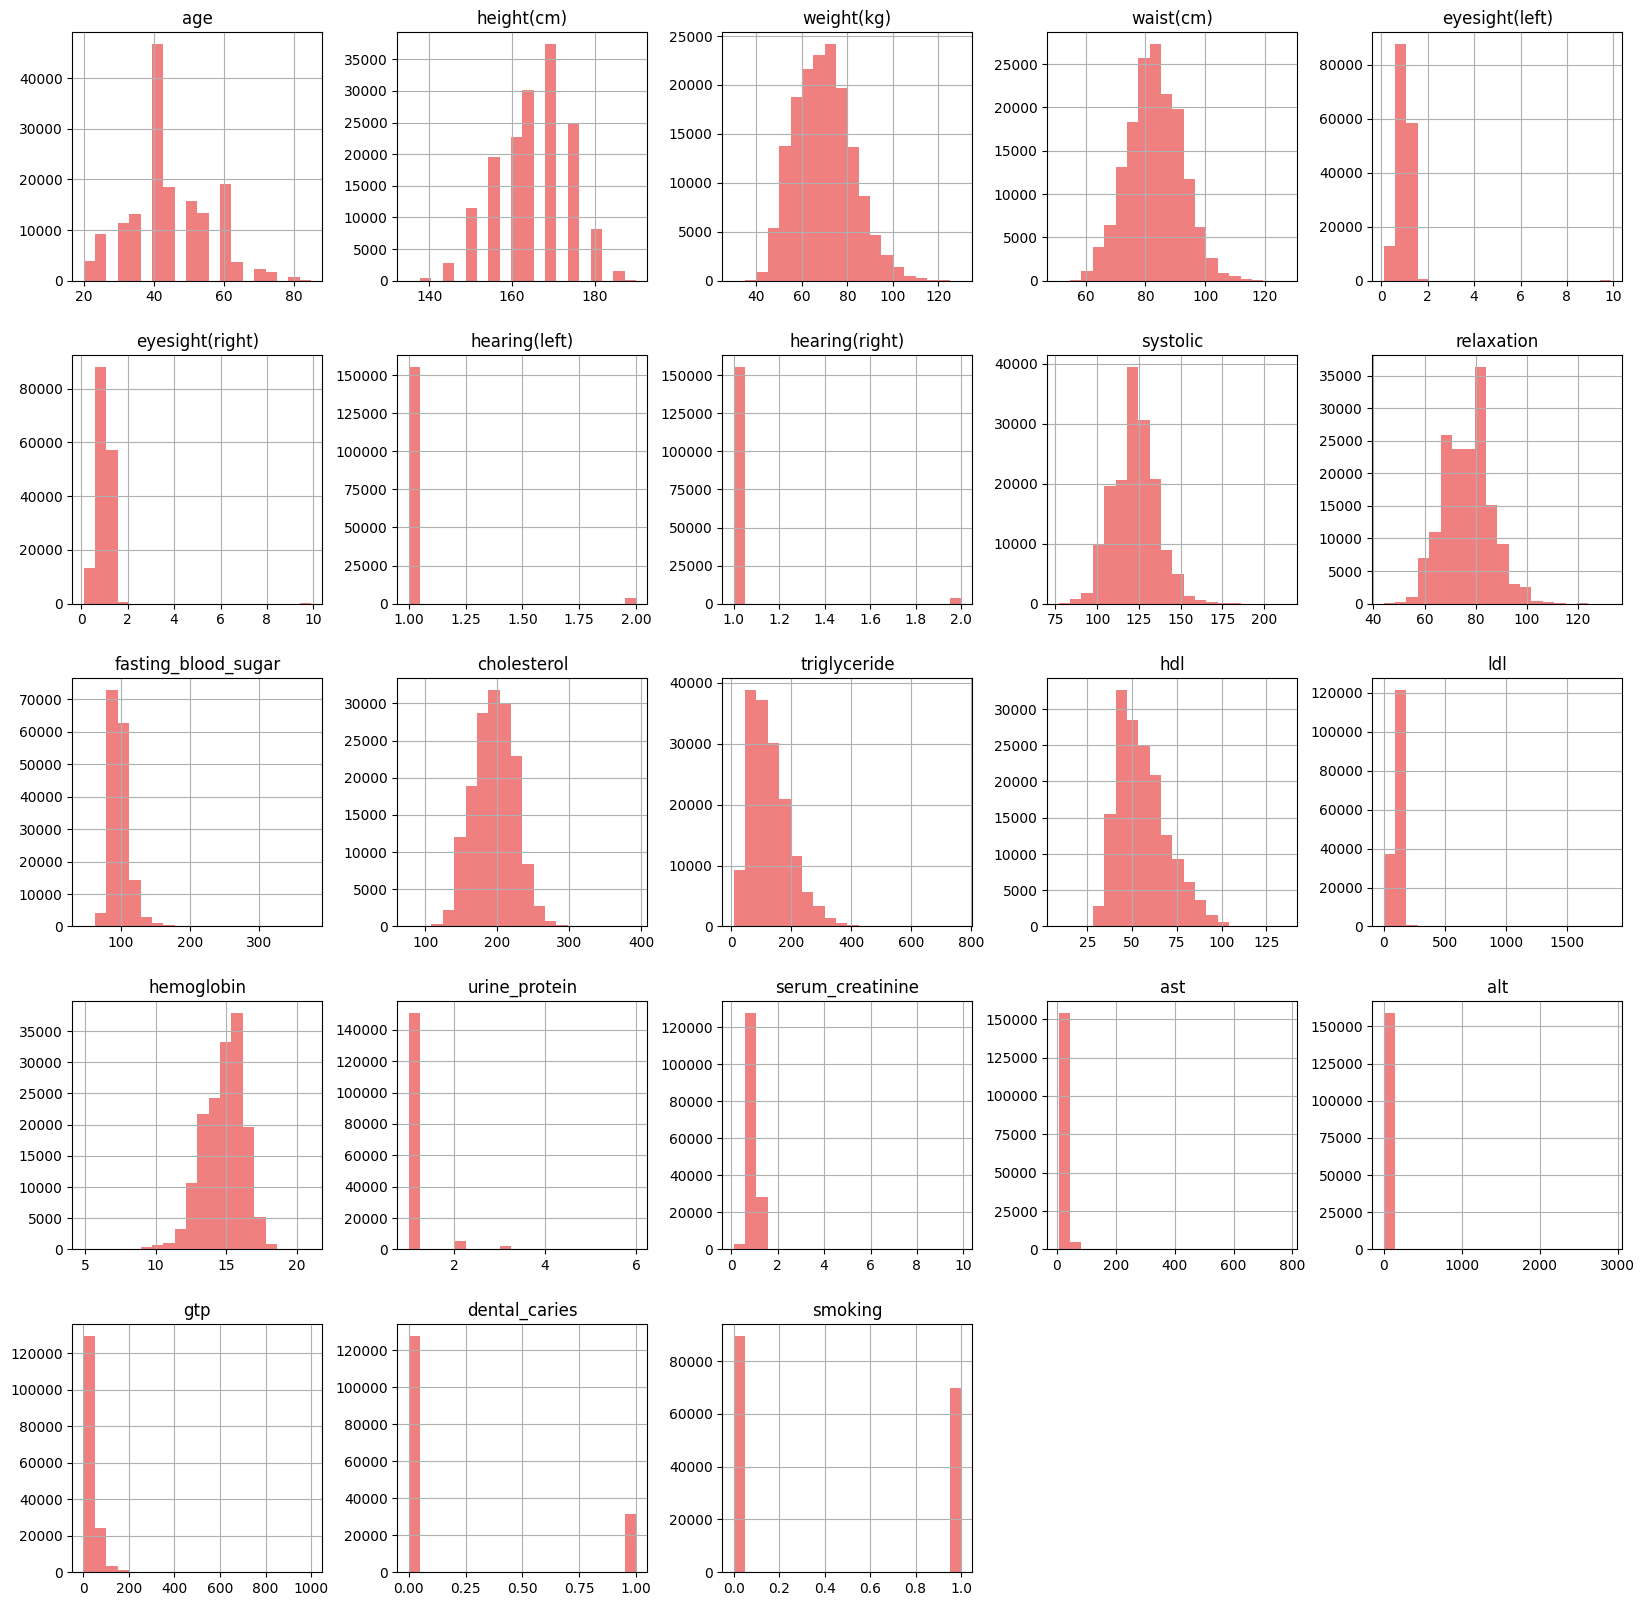

In [12]:
df_full_train.hist(bins=20, figsize=(20,20), color='lightcoral')
plt.show()

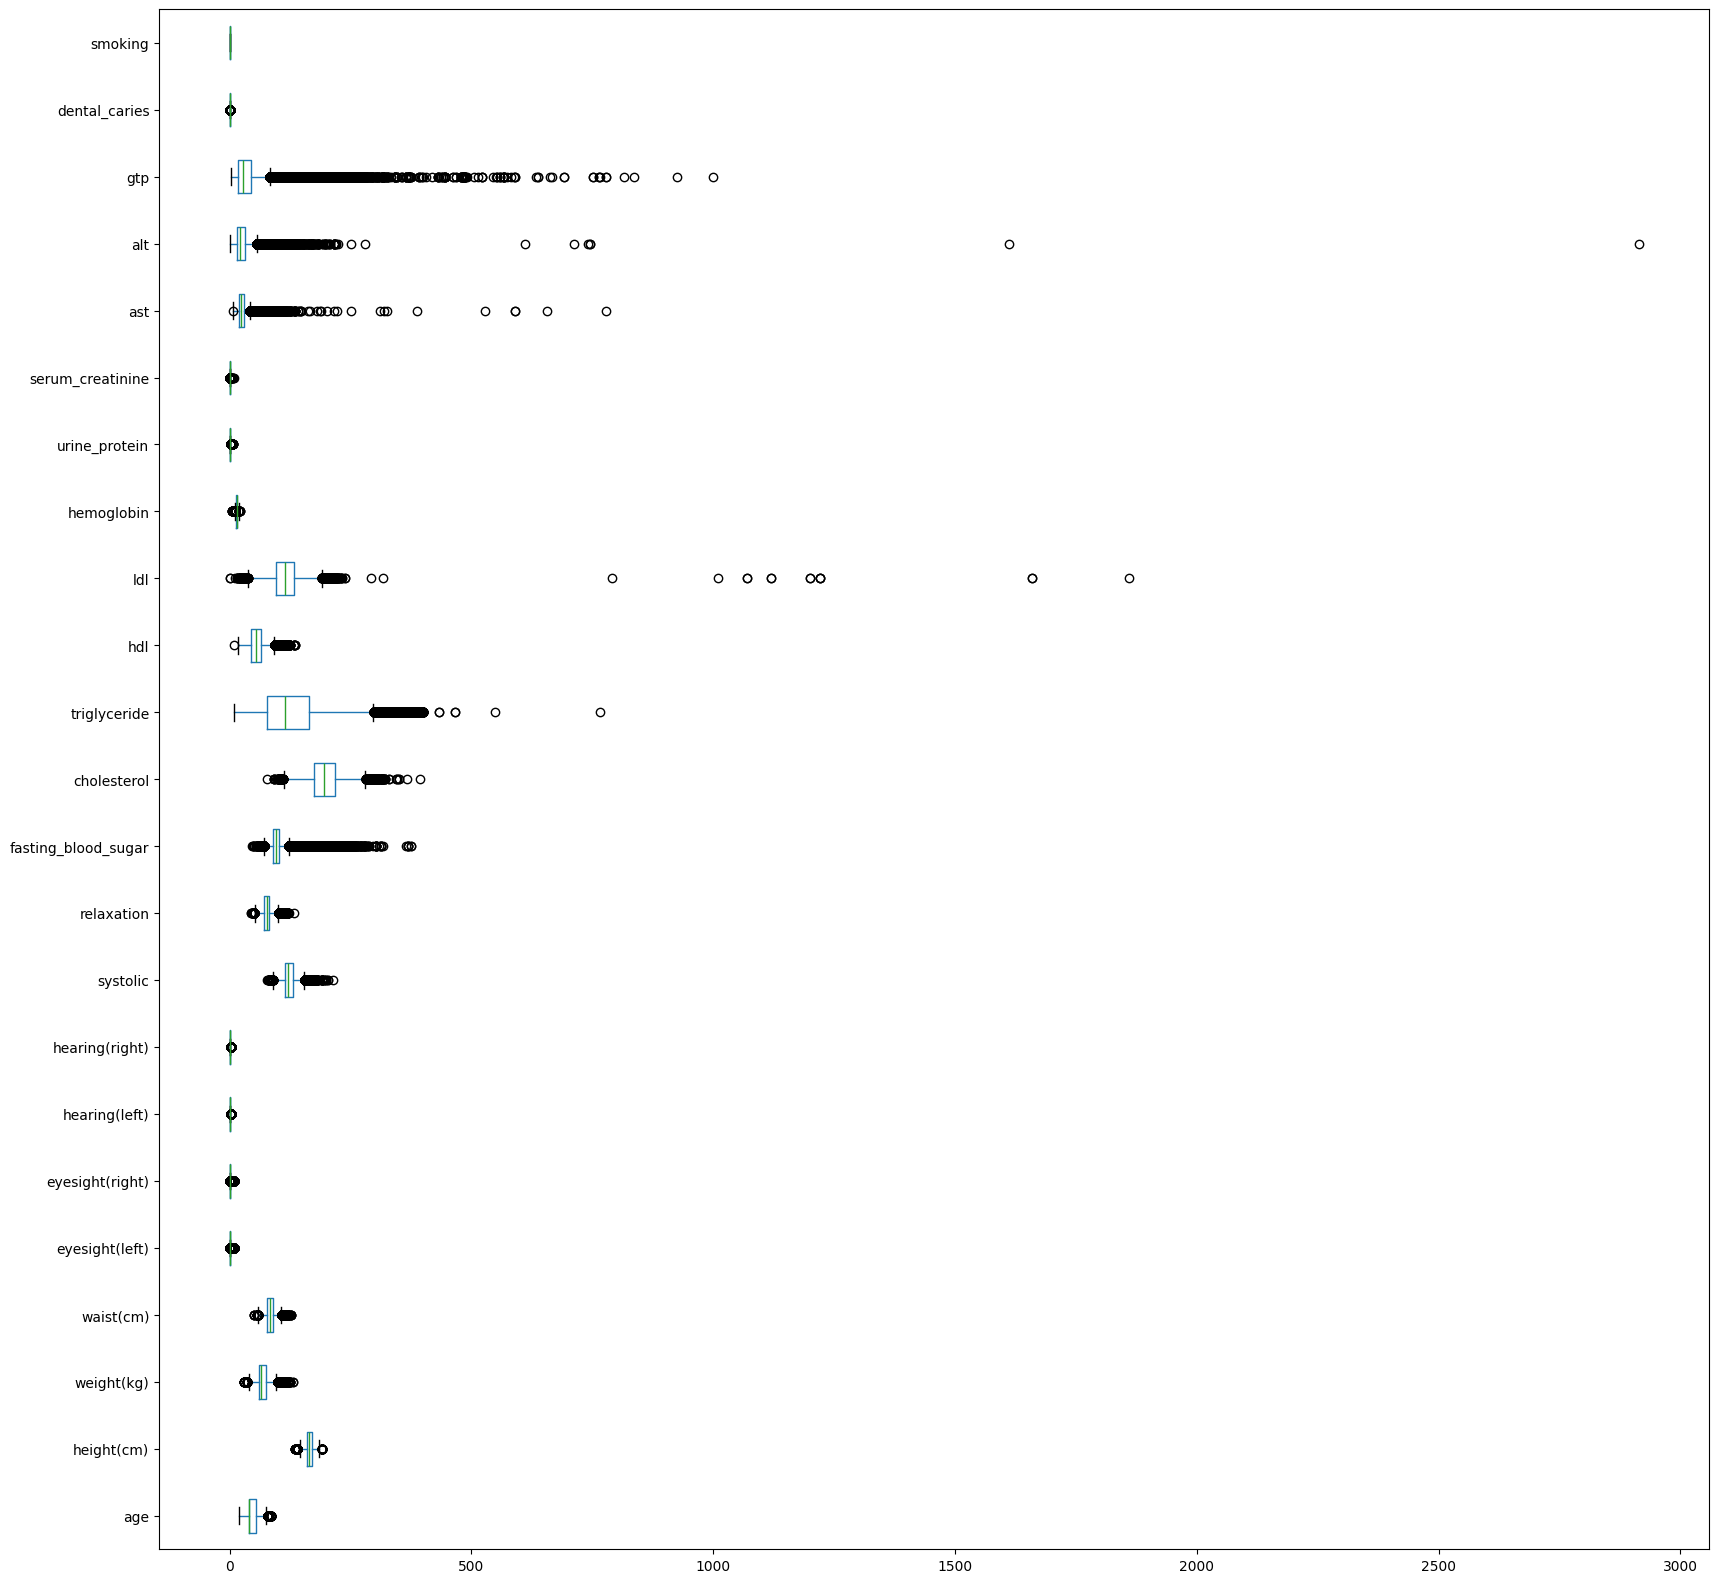

In [13]:
df_full_train.boxplot(figsize=(20,20), grid=False, vert=False)
plt.show()

**Correlation analysis**

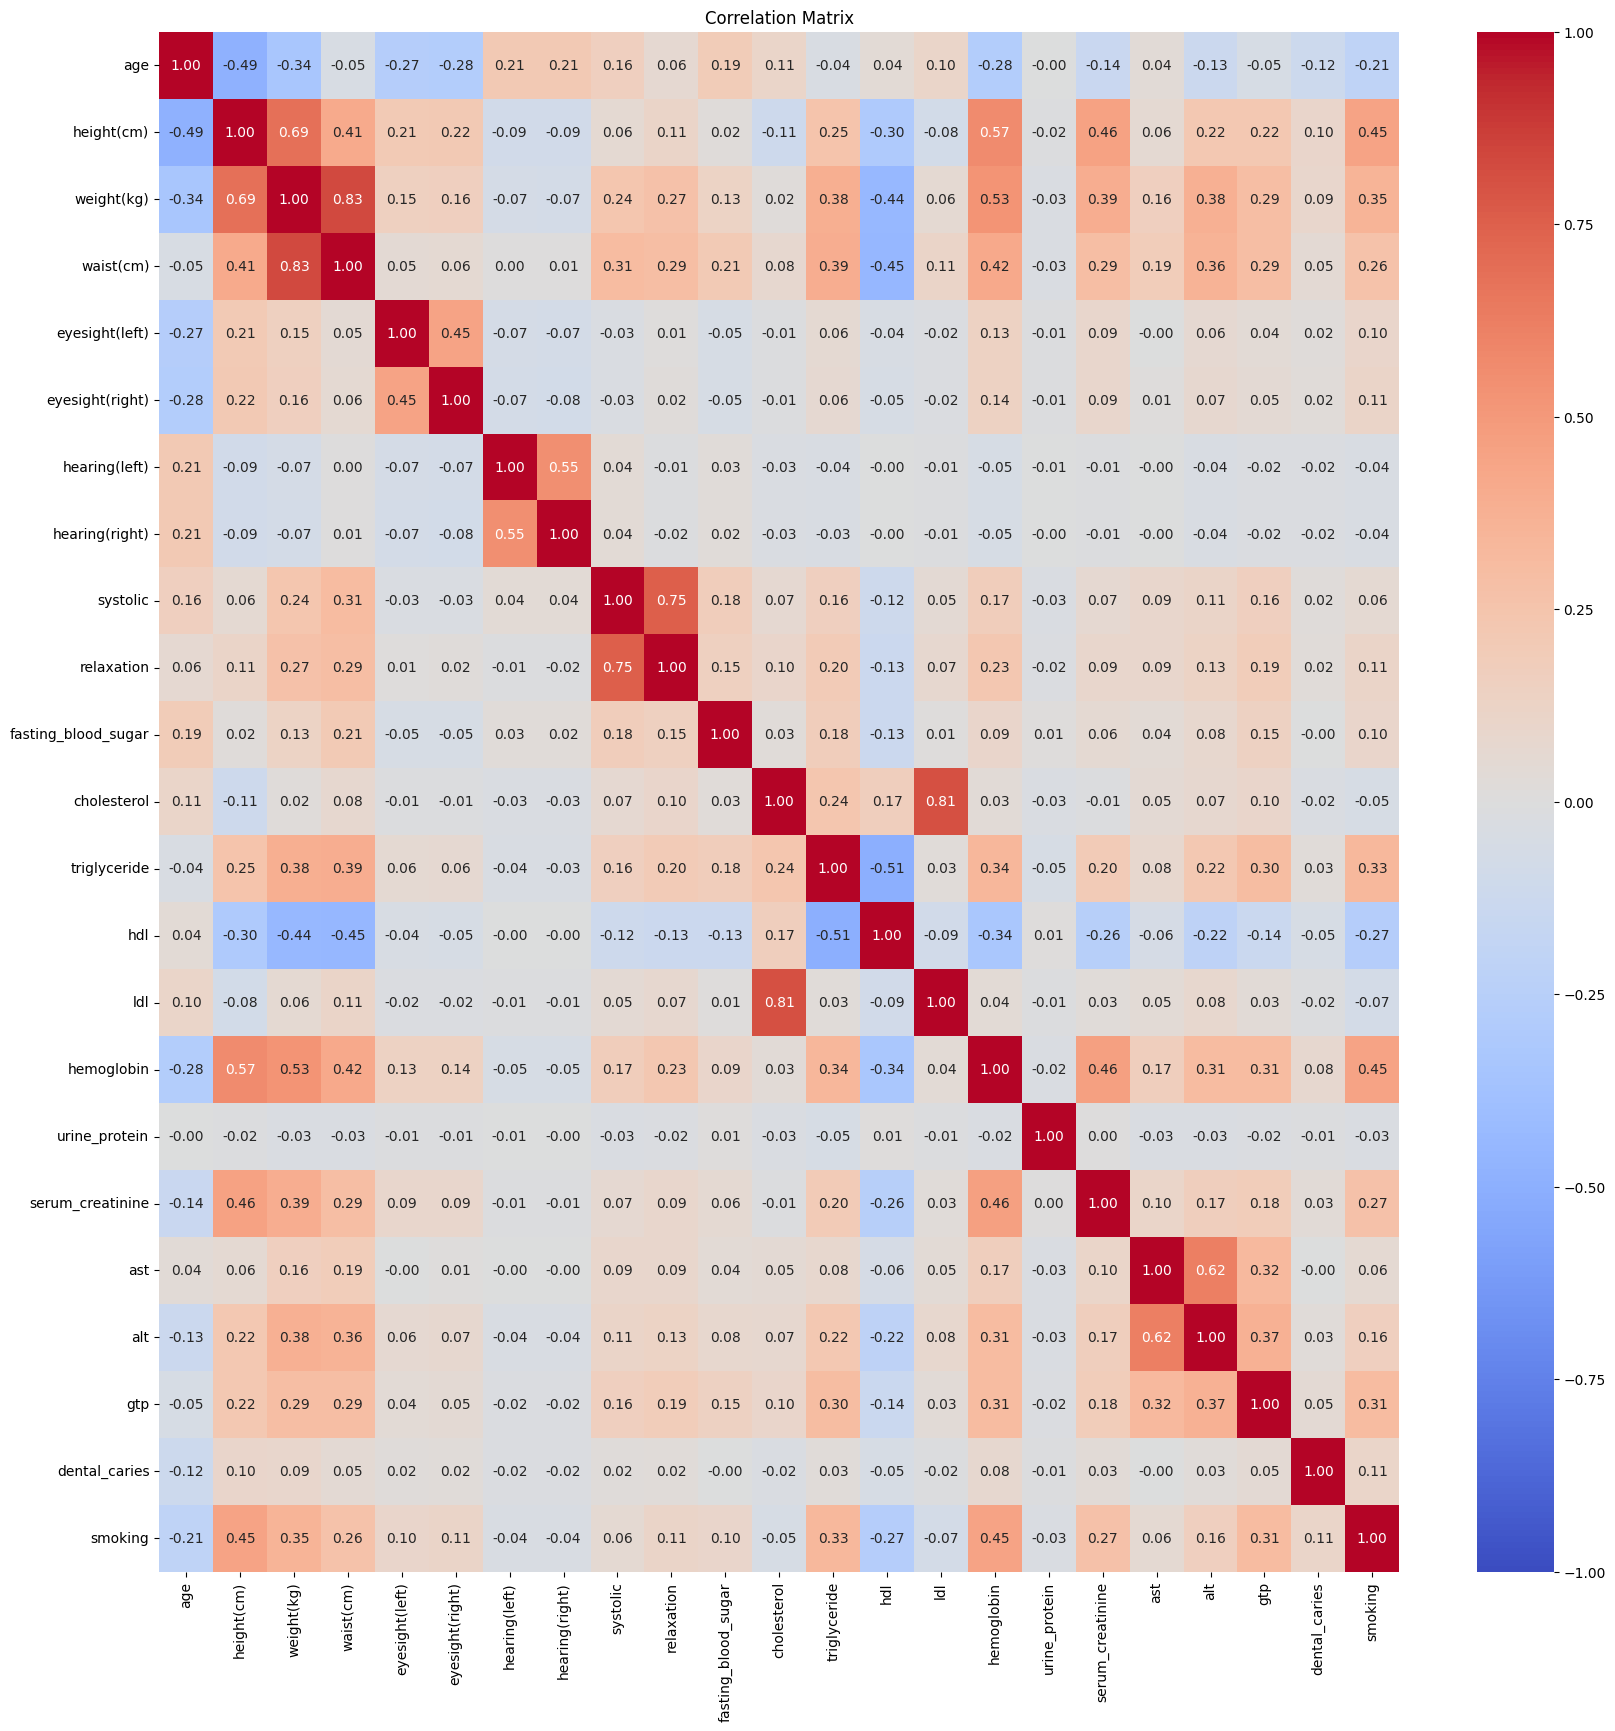

In [14]:
# 计算相关性矩阵
corr_matrix = df_full_train.corr()

# 可视化（热力图）
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1,vmax=1 , fmt=".2f",)
plt.title("Correlation Matrix")
plt.show()


In [15]:
# corrleation with target variable
df_corr = corr_matrix['smoking'].to_frame(name='CORR').drop(index='smoking')

df_corr

,CORR
age,-0.206033
height(cm),0.447111
weight(kg),0.351748
waist(cm),0.262715
eyesight(left),0.100420
eyesight(right),0.109781
hearing(left),-0.038219
hearing(right),-0.036858
systolic,0.058642
relaxation,0.109501


**Mutual Info**

In [16]:
df_mi = df_full_train.drop(columns='smoking').apply(calculate_mi)
df_mi = df_mi.to_frame(name='MI')

df_mi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings

,MI
age,0.025014
height(cm),0.135064
weight(kg),0.079116
waist(cm),0.046070
eyesight(left),0.009737
eyesight(right),0.011526
hearing(left),0.000753
hearing(right),0.000700
systolic,0.011299
relaxation,0.013655


In [17]:
df_corr_mi = pd.concat([df_corr, df_mi], axis=1)

df_corr_mi

,CORR,MI
age,-0.206033,0.025014
height(cm),0.447111,0.135064
weight(kg),0.351748,0.079116
waist(cm),0.262715,0.046070
eyesight(left),0.100420,0.009737
eyesight(right),0.109781,0.011526
hearing(left),-0.038219,0.000753
hearing(right),-0.036858,0.000700
systolic,0.058642,0.011299
relaxation,0.109501,0.013655


# Adversarial Validation

In [42]:
av_train = df_full_train.drop(columns='smoking')
av_test = df_test

av_train['belong'] = 0
av_test['belong'] = 1

av_full = pd.concat([av_train, av_test], axis=0)

In [43]:
# 准备X和y
av_X = av_full.drop(columns='belong')
av_y = av_full['belong']

# train_test_split（用于评估对抗模型）
av_X_train, av_X_val, av_y_train, av_y_val = train_test_split(
    av_X, av_y, test_size=0.2, random_state=1)

assert len(av_X) == len(av_X_train) + len(av_X_val)
assert len(av_y) == len(av_y_train) + len(av_y_val)

In [ ]:
# 使用随机森林
print("\n=== 随机森林对抗模型 ===")
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(av_X_train, av_y_train)

# 评估
rf_pred = rf_model.predict_proba(av_X_val)[:, 1]
rf_roc_auc = roc_auc_score(av_y_val, rf_pred)
rf_pr_auc = average_precision_score(av_y_val, rf_pred)
print(f"ROC_AUC: {rf_roc_auc:.4f}")
print(f"PR_AUC:{rf_pr_auc:.4f}")

print("\n=== 结果解读 ===")
if rf_roc_auc < 0.55 and rf_pr_auc < 0.55:
    print("✅ 训练集和测试集分布一致")
elif rf_roc_auc > 0.7 and rf_pr_auc > 0.7:
    print("⚠️ 警告：训练集和测试集分布差异显著！")
    print("可能原因：")
    print("- 数据来自不同时间段/来源")
    print("- 测试集包含训练集未见的特征值")
else:
    print("🔍 分布有轻微差异，建议检查特征重要性")


=== 随机森林对抗模型 ===
ROC_AUC: 0.5058
PR_AUC:0.3995

=== 结果解读 ===
✅ 训练集和测试集分布一致(AUC接近0.5)


---------------

# Data preparation

In [18]:
# set random seed num
seed=1

In [19]:
X_full_train = df_full_train.drop(columns='smoking')
y_full_train = df_full_train['smoking']

X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.2, random_state=seed)

X_test = df_test

assert len(X_full_train) == len(X_train) + len(X_val)
assert len(y_full_train) == len(y_train) + len(y_val)

# Modelling

## Base Model

In [20]:
# Base model (logistic regression) + 5-fold
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=seed)

aucs = []
praucs = []

for train_idx, val_idx in kfold.split(df_full_train):
    # get k-fold train & test
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    # get X, y
    X_train = df_train.drop(columns='smoking')
    X_val = df_val.drop(columns='smoking')

    y_train = df_train.smoking.values
    y_val = df_val.smoking.values
    
    # Create  model
    model = LogisticRegression(solver='liblinear', class_weight='balanced' ,random_state=seed)
    model.fit(X_train, y_train)
    
    # predict val
    y_pred = model.predict_proba(X_val)[:,1]
    
    # evaluation
    auc = roc_auc_score(y_val, y_pred)
    prauc = average_precision_score(y_val, y_pred)
    
    praucs.append(prauc)
    aucs.append(auc)

print('Logistic - ROC-auc = %0.4f ± %0.4f' % (np.mean(aucs), np.std(aucs)))
print('Logistic - PR-auc = %0.4f ± %0.4f' % (np.mean(praucs), np.std(praucs)))

Logistic - ROC-auc = 0.8344 ± 0.0023
Logistic - PR-auc = 0.7494 ± 0.0053


## Advanced Model

In [21]:
# Random forest - 5 fold (n_estimator | max_depth | min_samples_split | min_sample_leaf)
models = [
    ("Random Forest", RandomForestClassifier(random_state=seed))
]

# CV（using ROC-AUC score）
for name, model in models:
    roc_auc_scores = cross_val_score(model, X_full_train, y_full_train, cv=5, scoring='roc_auc')
    print('%s - CV ROC-auc Score: %.4f ± %.4f' %(name, np.mean(roc_auc_scores), np.std(roc_auc_scores)))
    pr_auc_scores = cross_val_score(model, X_full_train, y_full_train, cv=5, scoring='average_precision')
    print('%s - CV PR-auc Score: %.4f ± %.4f' %(name, np.mean(pr_auc_scores), np.std(pr_auc_scores)))
    


Random Forest - CV ROC-auc Score: 0.8573 ± 0.0010
Random Forest - CV PR-auc Score: 0.7844 ± 0.0015


In [22]:
# XGBoost - 5 fold
aucs = []
praucs = []

for t, v in kfold.split(df_full_train):
    df_train = df_full_train.iloc[t]
    df_val = df_full_train.iloc[v]
    
    X_train = df_train.drop(columns='smoking')
    X_val = df_val.drop(columns='smoking')
    
    y_train = df_train.smoking.values
    y_val = df_val.smoking.values
    
    model_xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=seed)
    
    model_xgb.fit(X_train, y_train)

    y_pred = model_xgb.predict_proba(X_val)[:,1]

    # evaluation
    auc = roc_auc_score(y_val, y_pred)
    prauc = average_precision_score(y_val, y_pred)
    
    praucs.append(prauc)
    aucs.append(auc)

print('XGBoost - ROC-auc = %0.4f ± %0.4f' % (np.mean(aucs), np.std(aucs)))
print('XGBoost - PR-auc = %0.4f ± %0.4f' % (np.mean(praucs), np.std(praucs)))


XGBoost - ROC-auc = 0.8651 ± 0.0016
XGBoost - PR-auc = 0.8014 ± 0.0030


## Hyperparameter Tuning

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

np.random.seed(seed=seed)

# 超参数分布
param_dist = {
    'max_depth': randint(3, 10),
    'eta': uniform(0.01, 0.3),
    'min_child_weight': randint(1, 30)
}

# 随机搜索最佳参数,并重新训练
random_search = RandomizedSearchCV(
    estimator= xgb.XGBClassifier(objective='binary:logistic', random_state=seed),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='average_precision',
    refit = True
)

random_search.fit(X_full_train, y_full_train)

# 输出最佳参数
print("Best Parameters:", random_search.best_params_)
print("Best PR-AUC Score: ", random_search.best_score_)
best_model_xgb = random_search.best_estimator_


Best Parameters: {'eta': np.float64(0.10402725344777285), 'max_depth': 9, 'min_child_weight': 26}
Best PR-AUC Score:  0.8038925766697037


## Final Model Testing

In [25]:
# Final model testing
models = [
    # ("Logistic Regression", LogisticRegression(solver='liblinear', random_state=seed)),
    # ("Random Forest", RandomForestClassifier(random_state=seed)),
    ("XGBoost", best_model_xgb)
]

for name, model in models:
    # model.fit(X_full_train, y_full_train)
    # full tain dataset
    y_pred = model.predict_proba(X_full_train)[:,1]
    print('%s - full train score: %.4f' %(name, average_precision_score(y_full_train, y_pred)) )
    # test dataset
    y_test_pred = model.predict_proba(X_test)[:,1]
    sample_submission['smoking'] = y_test_pred
    sample_submission.to_csv(f'submission{name}.csv', index=False)

XGBoost - full train score: 0.8585


# Terminal Code

In [ ]:
# ! pipenv install numpy pandas scikit-learn==1.7.0 flask gunicorn xgboost==3.0.4

Creating a Pipfile for this project...
Pipfile.lock not found, creating...
Locking  dependencies...
Locking  dependencies...
Updated Pipfile.lock 
(702ad05de9bc9de99a4807c8dde1686f31e0041d7b5f6f6b74861195a52110f5)!
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.
Installing numpy...
✔ Installation Succeeded
Installing pandas...
✔ Installation Succeeded
Installing scikit-learn==1.7.0...
✔ Installation Succeeded
Installing flask...
✔ Installation Succeeded
Installing gunicorn...
✔ Installation Succeeded
Installing xgboost==3.0.4...
✔ Installation Succeeded
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.
Installing dependencies from Pipfile.lock (2110f5)...
All dependencies are now up-to-date!
Upgrading numpy, pandas, scikit-learn==1.7.0, flask, gunicorn, xgboost==3.0.4 in
dependencies.
Building requirements...
Resolving dependencies....


In [ ]:
# ! gunicorn -b 0.0.0.0:9696 predict:app

[2025-09-06 05:01:30 +0000] [37061] [INFO] Starting gunicorn 23.0.0
[2025-09-06 05:01:30 +0000] [37061] [INFO] Listening at: http://0.0.0.0:9696 (37061)
[2025-09-06 05:01:30 +0000] [37061] [INFO] Using worker: sync
[2025-09-06 05:01:30 +0000] [37063] [INFO] Booting worker with pid: 37063
[2025-09-06 05:01:36 +0000] [37061] [INFO] Handling signal: int
^C
[2025-09-06 05:01:36 +0000] [37063] [INFO] Worker exiting (pid: 37063)


In [ ]:
# ! docker build -t mid-project .

[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.2s (1/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 326B                                       0.0s
 => [internal] load metadata for docker.io/library/python:3.12.1-slim      0.1s
[+] Building 0.4s (1/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 326B                                       0.0s
 => [internal] load metadata for docker.io/library/python:3.12.1-slim      0.3s
[+] Building 0.5s (1/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 326B                                       0.0s
 => [internal] load metadata for docker.

In [ ]:
# ! docker images

REPOSITORY    TAG       IMAGE ID       CREATED          SIZE
mid-project   latest    24c07bcdf35b   37 seconds ago   1.6GB


In [ ]:
# ! docker rmi -f $(docker images -aq)

Untagged: mid-project:latest
Deleted: sha256:ffe261ef95fe94ea3278bd4a99da6dfe843504f8fe9ad131039a38f98d4c1540


In [ ]:
# ! docker run -it --rm -p 9696:9696  mid-project:latest

[2025-09-06 05:10:08 +0000] [1] [INFO] Starting gunicorn 23.0.0
[2025-09-06 05:10:08 +0000] [1] [INFO] Listening at: http://0.0.0.0:9696 (1)
[2025-09-06 05:10:08 +0000] [1] [INFO] Using worker: sync
[2025-09-06 05:10:08 +0000] [7] [INFO] Booting worker with pid: 7


[2025-09-06 05:12:40 +0000] [1] [INFO] Handling signal: int
^C
[2025-09-06 05:12:40 +0000] [7] [INFO] Worker exiting (pid: 7)


# SHAP

In [ ]:
# 2. 导入SHAP库
import shap

# 3. 初始化SHAP解释器（以优化后的XGBoost模型为例）
explainer = shap.TreeExplainer(best_model_xgb)  # best_model_xgb为已训练的XGBoost模型
shap_values = explainer.shap_values(X_test)    # X_test为测试集特征

/tmp/ipykernel_8768/2285978577.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)


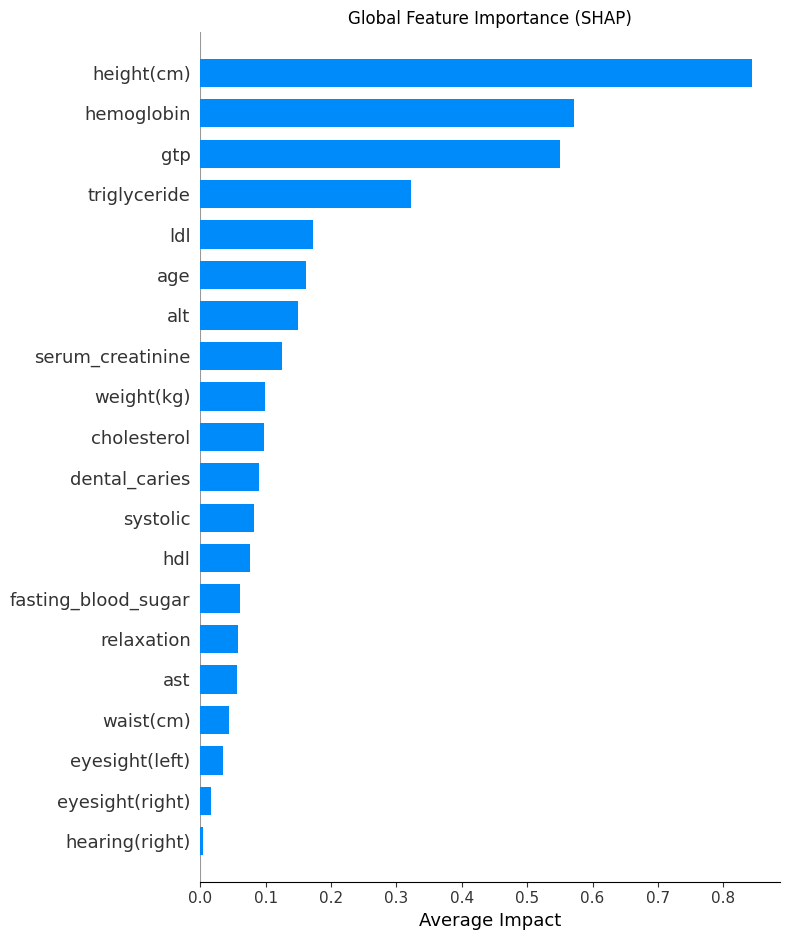

In [38]:
# 4.1 全局特征重要性（条形图）
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Global Feature Importance (SHAP)")
plt.xlabel('Average Impact')
plt.tight_layout()
plt.show()

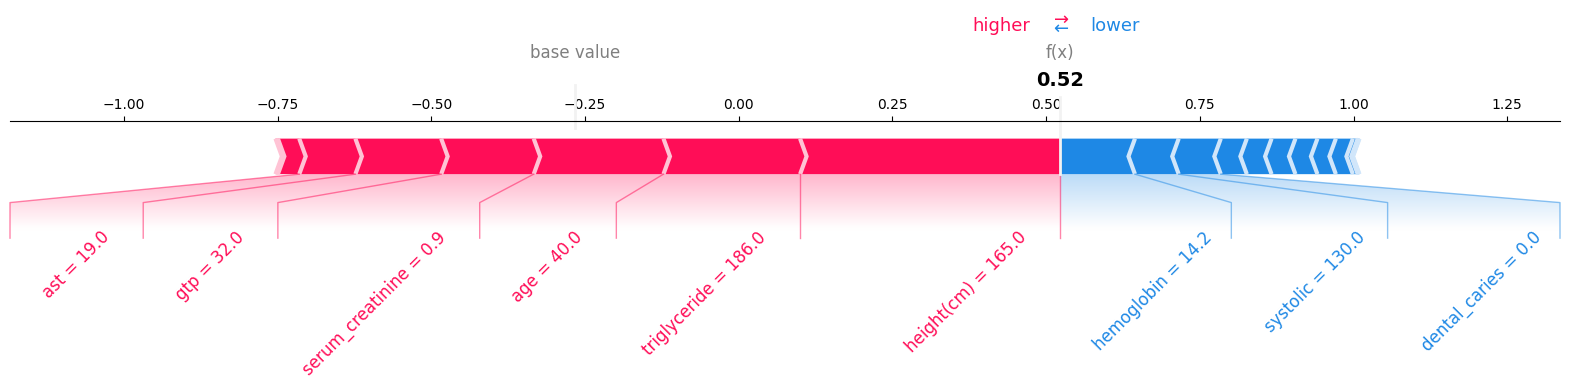

In [41]:
# 4.2 个体样本解释（力导向图）
sample_idx = 0  # 示例：分析测试集第1个样本
shap.force_plot(
    explainer.expected_value, 
    shap_values[sample_idx], 
    X_test.iloc[sample_idx],
    matplotlib=True,
    text_rotation=45
)
plt.show()
